**Team:**  Luke Chen, Ambrose Dukek, Jacob Arkadie

**Paper:** 

**Goals:**
Insert Stuff About Goals Here

**Plan:**
Put Stuff Here

**Movie Recommender System Using K-Means Clustering AND K-Nearest Neighbor:**



Step 1: imports

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619415 sha256=05c641c582ad09a92c926b813aa74f037a89e1298d602832adc01ca857f6669b
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# import statements
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import surprise

# imports for KMeans and KNN
from scipy import linalg as la
import numpy as np
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.sparse import linalg as spla
from time import time

Step 2: Read the CSV data information as dataframs in user and item variable

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
# make sure that items.csv, ratings.csv, and genre.csv from ml-100k are uploaded into /content/gdrive/My Drive/Recommender Systems/
# data can be found https://drive.google.com/drive/folders/1vjTW-9w1HMtPYph2qyoVJK1xRuXSgXEg?usp=sharing

Mounted at /content/gdrive/


In [ ]:
# read in ratings.csv
ml_data_ratings = pd.read_csv("/content/gdrive/My Drive/Recommender Systems/ratings.csv",sep=",",header=0,names=["userId", "movieId", "rating", "tstamp"]).fillna(0)
ml_data_ratings = ml_data_ratings.pivot(index = ["userId"],columns=["movieId"],values=["rating"])   # this is the utility matrix
ml_data_ratings = ml_data_ratings.fillna(0)

# read in genre.csv
ml_data_genre = pd.read_csv("/content/gdrive/My Drive/Recommender Systems/genre.csv", sep="|", header=0, names=["Genres", "ID"])
genres = ["title"] + ml_data_genre["Genres"].tolist()

# read in items.csv
ml_data_items = pd.read_csv("/content/gdrive/My Drive/Recommender Systems/items_reshape.csv", sep=",", header=0, names=genres)

print(ml_data_items)

                                          title  unknown  ...  War  Western
0                              Toy Story (1995)        0  ...    0        0
1                              GoldenEye (1995)        0  ...    0        0
2                             Four Rooms (1995)        0  ...    0        0
3                             Get Shorty (1995)        0  ...    0        0
4                                Copycat (1995)        0  ...    0        0
...                                         ...      ...  ...  ...      ...
1677                          Mat' i syn (1997)        0  ...    0        0
1678                           B. Monkey (1998)        0  ...    0        0
1679                       Sliding Doors (1998)        0  ...    0        0
1680                        You So Crazy (1994)        0  ...    0        0
1681  Scream of Stone (Schrei aus Stein) (1991)        0  ...    0        0

[1682 rows x 20 columns]


Step 3: Split the data into training and test data

In [ ]:
# split test and train data
def datasplit(ratio, data):
  '''
  ratio should be a float >=0 <=1
  data is a dataframe
  '''
  length = data.shape[0]
  train = ml_data_ratings.iloc[:int(length * ratio),:]
  test = ml_data_ratings.iloc[int(length * ratio + 1):,:]
  return train, test

train, test = datasplit(0.9, ml_data_ratings)
print(train.shape[0])
print(test.shape[0])

603
67


Step 4: Get utility matrix

In [ ]:
utility = train

Step 5: Using the WCSS method choose the right number of
clusters so that the K-means Clustering technique can be
applied to classify the movies according to the number of
clusters. 

In [ ]:
# figure out the best number of clusters with WCSS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# test between 1 and 20 clusters, borrowed from https://stackoverflow.com/questions/66555997/how-to-get-sse-for-each-cluster-in-k-means
def optimize_clusters(data):
  cluster_scores = []
  for c in range(1, 21):
    kmeans = KMeans(n_clusters=c)
    kmeans.fit(data)
    cluster_centers = [data[kmeans.labels_ == i].mean(axis=0) for i in range(c)]
    clusterwise_sse = [0] * c
    for point, label in zip(data, kmeans.labels_):
      clusterwise_sse[label] += np.square(point[1] - cluster_centers[label]).sum()
    cluster_score = sum(clusterwise_sse) / len(clusterwise_sse)
    cluster_scores.append((cluster_score, c))
  y, x = map(list,zip(*cluster_scores))
  return y, x

y, x = optimize_clusters(utility)

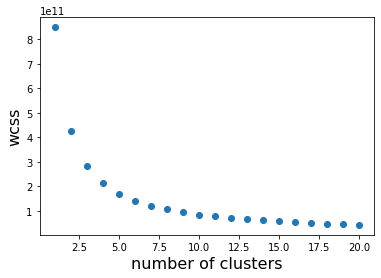

In [ ]:
plt.xlabel('number of clusters', fontsize=16)
plt.ylabel('wcss', fontsize=16)
plt.scatter(x, y)
plt.show()

Step 6: Define the utility clustered matrix after applying the
K-means clustering algorithm. Create the user x cluster matrix filled with user ratings for a *cluster*

In [ ]:
ratings = train
genre = ml_data_genre
items = ml_data_items

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5)   # use WCSS to determine proper number of clusters
                                    # OR just use the number of clusters stated in the paper
kmeans.fit(ratings,)

# obtain labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

pd.set_option("display.max_rows", ratings.describe().shape[1])
pd.DataFrame(centroids)

movie_names = items.title
genre_types = items.columns[1:]

items_arr = np.array(items)
genre_types_arr = np.array(items[genre_types])

In [ ]:
from math import e

user_distances = kmeans.transform(ratings)

# apply sigmoid function
ucm = [[]]
c2 = 0

for i in user_distances:
    c = 0
    for j in i:
        new_val = 5 / (1 + (e ** j))
        ucm[c2].append(new_val)
        c += 1
        if c > 4:
            break
    ucm.append([])
    c2 += 1

# print(pd.DataFrame(ucm[:-1]))

Step 7: Apply Pearson Correlation metric on utility clustered
matrix to calculate the similarity matrix between the users. the paper used only -1, 0, 1

In [ ]:
users = [userId for userId in range(0, train.shape[0])]
clusters = [c for c in range(0, 5)]
user_correlation = pd.DataFrame(0, index=users, columns=users)
user_cluster_ratings = pd.DataFrame(ucm[:-1])
print(user_cluster_ratings)

# https://leimao.github.io/blog/Cosine-Similarity-VS-Pearson-Correlation-Coefficient/
def pearson_similarity(user1, user2):
  return user_cluster_ratings.loc[user1, :].corr(user_cluster_ratings.loc[user2, :])

for user1 in users:
  for user2 in users:
    user_correlation.loc[user1, user2] = pearson_similarity(user1, user2)

In [ ]:
print(user_correlation)

          0         1         2    ...       600       601       602
0    1.000000  0.997586  0.998254  ...  0.998370  0.992850  0.991529
1    0.997586  1.000000  0.999744  ...  0.999358  0.998661  0.998155
2    0.998254  0.999744  1.000000  ...  0.999716  0.997513  0.997099
3    0.971460  0.985326  0.982155  ...  0.980899  0.992776  0.993546
4    0.990730  0.997364  0.996673  ...  0.996624  0.999087  0.999248
5    0.998730  0.999706  0.999925  ...  0.999837  0.997276  0.996613
6    0.995078  0.999522  0.998856  ...  0.998031  0.999527  0.999446
7    0.986018  0.994725  0.993920  ...  0.993607  0.997690  0.998436
8    0.998125  0.999954  0.999887  ...  0.999605  0.998167  0.997601
9    0.998397  0.999885  0.999926  ...  0.999571  0.997777  0.997232
10   0.998742  0.999611  0.999823  ...  0.999918  0.997202  0.996428
11   0.999165  0.999565  0.999788  ...  0.999652  0.996758  0.995964
12   0.997526  0.999765  0.999901  ...  0.999743  0.998138  0.997782
13   0.999956  0.997945  0.998665 

Step 8: Normalize the values stored in utility matrix.

Step 9: Guess() function takes two parameters as input userID and topN users which is used by KNN to predict the movie ratings for topN similar users.

In [ ]:
import heapq
def GetTopNNeighbors(userID,n):
  data = user_correlation.iloc[userID].tolist() #Change test to similarity matrix
  count = 0;
  data_tuples = []
  for name,values in user_correlation.iterrows():
    heapq.heappush(data_tuples,(data[count],name))

  final_data = heapq.nlargest(n, data_tuples)
  return final_data

def Guess(userId,n):
  top_neighbors = GetTopNNeighbors(userId,n)
  user_predicted_ratings = []
  for(col_name,col_data) in train.iterrows():
    movie_score = col_data.values.tolist()
    sum = 0
    num_rated = 0
    for x in top_neighbors:
      if movie_score[x[1]] != 0:
        sum += movie_score[x[1]]
        num_rated += 1
    
    if num_rated == 0:
      user_predicted_ratings.append(0)
    else:
      user_predicted_ratings.append(sum/num_rated)
  return user_predicted_ratings
#print(Guess(11,5))

def GetTop5Movies(ratings):

  data = []
  count = 0
  for name in ml_data_items["title"]:
    heapq.heappush(data,(ratings[count],name))
  final_data = heapq.nlargest(5, data)

  for x in range(len(final_data)):
    print(f"{x+1}. {final_data[x][1]}")




GetTop5Movies(Guess(600,5))

1. � k�ldum klaka (Cold Fever) (1994)
2. unknown
3. Zeus and Roxanne (1997)
4. Young Poisoner's Handbook, The (1995)
5. Young Guns II (1990)


Step 10: Test data frame ratings are used for comparison
while using the guess function for predicting the ratings of
test users.  
Step 11: RMSE is calculated to evaluate the accuracy of the
model.

# Evaluation
Find number of K-means clusters  
Split data into clusters  
Find neighborhoods using clusters  
